In [63]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns
import cvxpy as cp
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

## Get Universe - Current S&P 500 stocks that exhisted in 2002

In [64]:
"""
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime(2000,1,1)
end = datetime(2022,1,1)
data = yf.download(tickers, start=start, end=end)

data.index = pd.to_datetime(data.index)
data = data.sort_index()
SP_Close = data['Adj Close']
SP_Close=SP_Close.dropna(axis=0, how='all')
SP_Close=SP_Close.dropna(axis=1)
pd.set_option('display.max_rows', 20 )
SP_Close
"""

"\nresp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')\nsoup = bs.BeautifulSoup(resp.text, 'lxml')\ntable = soup.find('table', {'class': 'wikitable sortable'})\ntickers = []\nfor row in table.findAll('tr')[1:]:\n    ticker = row.findAll('td')[0].text\n    tickers.append(ticker)\n\ntickers = [s.replace('\n', '') for s in tickers]\nstart = datetime(2000,1,1)\nend = datetime(2022,1,1)\ndata = yf.download(tickers, start=start, end=end)\n\ndata.index = pd.to_datetime(data.index)\ndata = data.sort_index()\nSP_Close = data['Adj Close']\nSP_Close=SP_Close.dropna(axis=0, how='all')\nSP_Close=SP_Close.dropna(axis=1)\npd.set_option('display.max_rows', 20 )\nSP_Close\n"

In [65]:
#read in stock data from pi
SP_Close = pd.read_pickle('SP_Close.pkl')
SP_train = SP_Close[:'2018-01-01']

In [66]:
SP_train.head()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,44.221344,0.854541,3.025873,18.25000,9.347846,16.274675,29.523603,6.713816,25.847561,8.052906,...,44.580296,1.278264,5.451855,12.421493,7.445602,19.671473,6.852272,4.861766,25.027779,38.801506
2000-01-04,40.843311,0.782494,2.819287,17.81250,9.080765,14.909398,28.030031,6.643880,25.847561,7.660817,...,42.912186,1.238933,5.508176,11.954857,7.617051,19.294680,6.852272,4.764044,24.666668,36.922596
2000-01-05,38.309803,0.793945,3.038025,18.00000,9.064073,15.204173,28.439224,6.538982,25.599024,7.178244,...,42.036430,1.219267,5.485648,12.588147,7.910958,20.346552,6.970727,4.788472,25.138889,36.878899
2000-01-06,36.851112,0.725238,3.268915,18.03125,9.381230,15.328291,27.661741,6.573946,25.940754,6.740914,...,42.495152,1.290063,5.429327,13.177001,7.837479,21.398418,6.979842,4.747756,23.777779,37.403233
2000-01-07,39.922039,0.759592,3.694239,17.93750,9.481387,16.072985,28.439224,6.678852,26.531029,7.540174,...,45.706272,1.270398,5.485648,12.743696,7.837479,21.335625,6.961617,4.641887,23.513889,37.490639


In [67]:
SP_train.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,65.034782,41.731140,86.004715,191.639999,52.917374,175.000000,81.833565,35.416145,106.914101,103.889999,...,90.357903,28.866503,97.872253,29.092234,42.437065,66.389351,63.499165,76.503891,105.150002,45.769455
2017-12-26,64.938217,40.672424,86.739548,189.539993,52.982433,174.440002,81.630928,35.477833,107.545258,103.800003,...,91.231949,28.866503,97.528107,29.192152,42.067673,66.397224,63.923660,76.308914,104.790001,45.350365
2017-12-27,64.986504,40.679585,86.134933,190.419998,53.419315,175.360001,82.063828,35.460205,107.261719,104.580002,...,91.323959,28.931648,97.724762,29.225464,42.360115,66.333992,63.701767,76.503891,104.949997,45.216610
2017-12-28,65.131348,40.794033,86.125641,190.550003,53.410019,175.550003,82.321709,35.486645,107.307449,105.070000,...,91.452782,29.220720,97.360954,29.358677,42.608257,66.428864,64.173187,76.754570,104.279999,45.778381
2017-12-29,64.811005,40.352901,85.409393,187.410004,53.047497,175.240005,81.999352,35.319210,107.197662,104.830002,...,90.854729,29.171869,97.016815,29.358677,42.634838,66.128418,63.593575,75.770409,103.800003,45.323620


## Testing Initial Portfolio without Bayes

In [68]:
five_year_data=SP_Close[:1265] #5 years of data
five_year_data.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-07,13.948145,1.057321,11.317923,14.29,15.050692,29.384233,23.419283,14.685472,22.294916,34.282318,...,37.189400,6.975882,10.584788,13.893993,9.064570,28.189127,24.471771,12.140292,53.099998,49.812916
2005-01-10,13.880588,1.052894,11.317923,14.42,15.196447,29.404230,23.327053,14.806506,22.310617,34.222351,...,37.003414,7.007394,10.730645,13.951578,9.189453,28.296703,25.020788,12.142917,53.840000,49.843578
2005-01-11,13.641056,0.985713,11.345287,14.31,14.917611,29.054298,23.109659,14.598061,22.352486,32.373302,...,36.913879,7.011895,10.605624,13.819960,9.220676,28.223104,25.020788,12.182205,51.669998,49.874241
2005-01-12,13.622632,0.999455,11.349197,14.17,14.952654,29.484215,23.425869,14.503919,22.148371,31.953520,...,37.251415,7.058410,10.684803,13.782939,9.210265,28.642065,24.935287,12.085085,50.910000,49.406685
2005-01-13,13.333963,1.065719,11.161545,12.45,14.665908,29.104290,23.122826,14.692193,21.719221,31.763618,...,36.948326,7.074916,10.605624,13.686286,9.298729,28.619408,24.669779,11.911839,51.060001,48.831833


## Look at some correlations and clustering to gather ideas

In [69]:
#shrinkage
def calculate_posterior_mean(prior_pop, like_pop): #for returns use geo mean then multiply by 252 to annualize at end
    w0 = prior_pop.std()
    mu0 = prior_pop.mean() - w0**2/2
    w = like_pop.std()
    dbar = like_pop.mean() - w**2/2

    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    return mu_s * 252

## Markowitz Rebalancer

In [70]:
def Markowits_Bayes_Rebalance(securities_vector, rebalance_period,prior_period,update_period=0,verbose=True,weight_bounds=(-.01,.1)):
    #Bayesian update not yet implemented
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    for p in range(0,len(securities_vector)-prior_period,rebalance_period):
        
        prior_vector = securities_vector[p:prior_period+p]
        
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
            
        mu = mean_historical_return(prior_vector)
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df

In [71]:
def Portfolio_backtest(weight_vector, securities_vector=SP_train,daily_rebalance = False,title=None):
    weight_vector_n = weight_vector
    weight_vector_n = weight_vector.reindex(weight_vector.index.union(securities_vector.index))
    weight_vector_n = weight_vector_n[weight_vector.index[0]:]
    return_frame = np.exp(np.log(securities_vector).diff())-1
    return_frame = return_frame[weight_vector.index[0]:]
    if daily_rebalance:
        weight_vector_n=weight_vector_n.ffill()
    else:
        for p in range(len(weight_vector_n)):
            if np.isnan(weight_vector_n.iloc[p,1]):
                new_weights_unnormalized = weight_vector_n.iloc[p-1,:]*(return_frame.iloc[p-1,:]+1)
                weight_vector_n.iloc[p,:] = new_weights_unnormalized/sum(new_weights_unnormalized)
                


    weighted_returns=weight_vector_n.shift(1)*return_frame
    port_returns = np.sum(weighted_returns, axis=1) #shift so that we are using the weights we had over that period rather than the ones we found with hindsight
    port_returns = port_returns[weight_vector.index[0]:]
    total_return=(port_returns+1).cumprod()
    total_return.plot()
    reports.metrics(port_returns,mode='basic')
    plt.title('Cumulative Return')
    if title != None:
        plt.title(title)
        plt.savefig(title)
    return total_return

In [25]:
monthly_vanilla_markowitz = Markowits_Bayes_Rebalance(SP_train,63,253*4,weight_bounds=(-.002,.2),verbose=False) 

## Implement Clustering Influenced Dynamic Constraints

In [72]:
def Cluster_Constraints(clusters,u_coef,l_coef): # weight coef for how overweight you can go
    cluster_list = set(clusters.cluster)
    cluster_map = dict(zip(clusters.index,clusters.cluster))
    cluster_totals=[clusters.value_counts()[x] for x in cluster_list]
    cluster_pct=np.array(cluster_totals)/len(clusters)
    cluster_upper_l = dict(zip(cluster_list, cluster_pct*u_coef))
    cluster_lower_l = dict(zip(cluster_list, - l_coef*cluster_pct))
    return cluster_map, cluster_upper_l, cluster_lower_l

In [73]:
#for testing preset clusters
def get_clusters(corr, cluster_number = 45, Thresh = None):
    if Thresh == None:
        cluster = AgglomerativeClustering(n_clusters=cluster_number, affinity='euclidean', linkage='ward')
    else:
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=Thresh) 
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values)
    stock_clusters=stock_clusters.set_index(0)
    stock_clusters['cluster']=kclusters
    return stock_clusters

In [74]:
class constrained_clusterings_precomputed:
    
    def __init__(self,lookback):
        llist = [1,2,3,4,5]
        if (int(lookback) != lookback) or (int(lookback) not in llist):
            raise ValueError("Only lookback periods of",llist,"supported")
            
        self.df = pd.read_pickle(str(int(lookback))+'.pkl')
        self.names_df = pd.read_pickle('names.pkl')
        
#         corr_threshold = 0.7
#         pct_threshold = 0.1
#         date = datetime.strptime('3-31-2030','%m-%d-%Y')
        
            
    def calcthresholds(self,corr_threshold,pct_threshold,date,DEBUG=False):
        if date < min(self.df.index):
            raise ValueError("Date must be >=",min(self.df.index))
        if date > max(self.df.index):
            print("WARNING: USING",max(self.df.index),"FOR INPUT DATE",date)
        inddate = max(self.df.index[self.df.index <= date])
#         print(inddate)
#         print(self.df.loc[inddate])
        if DEBUG:
            print("DEBUG: USING",inddate,"FOR INPUT DATE",date)
        
        clusters = self.df.loc[inddate]['Clusters']
        numstocks = self.df.loc[inddate]['Numstocks']
        internals = self.df.loc[inddate]['Corrs']
        sz = clusters.shape[0]
        
        tmp = np.sum((internals<corr_threshold)*(numstocks/sz),axis=1)<pct_threshold
        ret = (np.arange(0,sz)+1)[tmp]
        if ret.shape[0] <= 0:
            return None
        OPTIMAL_NUMBER_OF_CLUSTERS = ret[0]
        if DEBUG:
            print("DEBUG: OPTIMAL NUMBER OF CLUSTERS:",OPTIMAL_NUMBER_OF_CLUSTERS)
        
        ret_df = self.names_df
        ret_df = ret_df.set_index(0)
        ret_df['cluster'] = clusters[OPTIMAL_NUMBER_OF_CLUSTERS-1,:].astype(int)
        
#         print(OPTIMAL_NUMBER_OF_CLUSTERS)
#         print(ret_df)
        return ret_df

In [75]:
import os
filelist = ['1.pkl','2.pkl','3.pkl','4.pkl','5.pkl','names.pkl']
for file in filelist:
    if not os.path.exists(file):
        raise ValueError("All of",filelist,"must be present")
        
look1 = constrained_clusterings_precomputed(1)
look2 = constrained_clusterings_precomputed(2)
look3 = constrained_clusterings_precomputed(3)
look4 = constrained_clusterings_precomputed(4)
look5 = constrained_clusterings_precomputed(5)

In [76]:
def get_clusters_precomputed(lookback,corr_threshold,pct_threshold,date,DEBUG=False):
    llist = [1,2,3,4,5]
    if (int(lookback) != lookback) or (int(lookback) not in llist):
        raise ValueError("Only lookback periods of",llist,"supported")
        
    # Apparently pattern matching wasn't implemented until Python 3.10
    if lookback == 1:
        return look1.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 2:
        return look2.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 3:
        return look3.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 4:
        return look4.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    elif lookback == 5:
        return look5.calcthresholds(corr_threshold,pct_threshold,date,DEBUG)
    else:
        raise ValueError("Something went wrong")

In [77]:
import warnings
warnings.filterwarnings('ignore')

In [91]:
def Markowits_Bayes_Cluster_Rebalance(securities_vector, rebalance_period=21,prior_period = 253*5, update_period=0,
                                      verbose=False,weight_bounds=(-.005,.15), cluster_u_coef=2, cluster_l_coef=-.05,
                                      corr_thresh = .75,leave_out_pct = .05, clust_num = None, reverse_prior=False):
    z=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    predicted_likelihood_returns = []
    predicted_posterior_returns = []
    dates=[]
    cluster_list=[]
    num=clust_num
    
    for p in range(0,len(securities_vector)-prior_period,rebalance_period): #
        
        prior_vector = securities_vector[p:prior_period+p]
        update_vector = securities_vector[prior_period+p-update_period:prior_period+p]
        if verbose:
            print("Iteration " + str(z) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
            
        
        if clust_num == None:
            clusters= get_clusters_precomputed(prior_period/253,corr_thresh, leave_out_pct, date=prior_vector.index[-1])
            num = clusters.max().values[0]
            cluster_list.append(max(clusters))    
        else:
            clusters = get_clusters(prior_vector.corr(), cluster_number = clust_num)
            cluster_list.append(clust_num) 
        c_map, c_upper, c_lower = Cluster_Constraints(clusters,cluster_u_coef,cluster_l_coef)
        
        mu = mean_historical_return(prior_vector) ###
        predicted_likelihood_returns.append(mu.copy())   ###
        
        if update_period != 0:
            if reverse_prior:
                for i in range(num):
                    stocksNcluster = clusters.loc[clusters['cluster']==i].index
                    for stock in stocksNcluster:
                        mu.loc[stock] = calculate_posterior_mean(prior_vector[stock].pct_change().dropna().to_numpy(),
                                                                 update_vector[stocksNcluster].pct_change().dropna().to_numpy())
            else:
                for i in range(num):
                    stocksNcluster = clusters.loc[clusters['cluster']==i].index
                    for stock in stocksNcluster:
                        mu.loc[stock] = calculate_posterior_mean(prior_vector[stocksNcluster].pct_change().dropna().to_numpy(),
                                                                 update_vector[stock].pct_change().dropna().to_numpy())
        predicted_posterior_returns.append(mu) ###
            
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        if cluster_u_coef<100 and cluster_l_coef>-100: ef.add_sector_constraints(c_map, c_lower, c_upper)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        z+=1
    cluster_ts=pd.DataFrame(cluster_list)
    cluster_ts.index=dates
    cluster_ts.columns = ['Clusters']
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates
    
    predicted_likelihood_returns = pd.DataFrame(predicted_likelihood_returns) ###
    predicted_likelihood_returns.index = dates ###
    
    predicted_posterior_returns = pd.DataFrame(predicted_posterior_returns) ###
    predicted_posterior_returns.index = dates ###
    
    return weight_df ,predicted_likelihood_returns, predicted_posterior_returns

In [131]:
weights, likelihood, posterior = Markowits_Bayes_Cluster_Rebalance(SP_train,
                                                                   rebalance_period = 21*3, 
                                                                   prior_period = 253*4,
                                                                   update_period = 21*3, 
                                                                   corr_thresh = .8,
                                                                   reverse_prior = True,
                                                                   verbose=False) 

### reversed prior

In [134]:
weights, likelihood, posterior = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4,21*3, weight_bounds=(-.002,.2), cluster_u_coef=3, cluster_l_coef=-.05,verbose=False,reverse_prior=True)
actual = SP_train.loc[weights.index].pct_change().shift(-1) # actual returns for next period


In [135]:
df = pd.concat([(likelihood.subtract(actual)**2).mean(axis=1),(posterior.subtract(actual)**2).mean(axis=1)],axis=1)
df = df.rename(columns={0:"likelihood MSE",1:"posterior MSE"})

<AxesSubplot:>

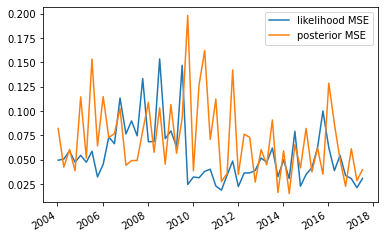

In [136]:
df.plot()

### regular prior

<AxesSubplot:>

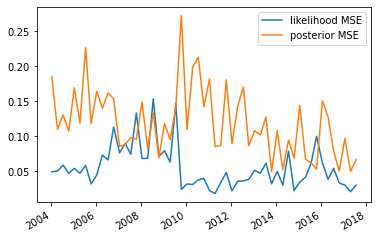

In [138]:
weights, likelihood, posterior = Markowits_Bayes_Cluster_Rebalance(SP_train,21*3,253*4,21*3, weight_bounds=(-.002,.2), cluster_u_coef=3, cluster_l_coef=-.05,verbose=False,reverse_prior=False)
actual = SP_train.loc[weights.index].pct_change().shift(-1) # actual returns for next period
df = pd.concat([(likelihood.subtract(actual)**2).mean(axis=1),(posterior.subtract(actual)**2).mean(axis=1)],axis=1)
df = df.rename(columns={0:"likelihood MSE",1:"posterior MSE"})
df.plot()